## Sea Level Projections

Notebook environment to migrate netcdf files to CoG.

In [1]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

<IPython.core.display.Javascript object>

### Configure OS independent paths

In [2]:
# Import standard packages
import os
import pathlib
import sys
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import numpy.ma as ma
import rasterio
import rioxarray as rio
from datacube.utils.cog import write_cog

# Make root directories importable by aslpending root to path
cwd = pathlib.Path().resolve()
sys.path.append(os.path.dirname(cwd))

# Get root paths
home = pathlib.Path().home()
root = home.root
tmp_dir = home.joinpath("data", "tmp")

# Import custom functionality
from coclicodata.drive_config import p_drive
from coclicodata.etl.cf_compliancy_checker import check_compliancy, save_compliancy
from coastmonitor.io.utils import name_block

# Define (local and) remote drives
coclico_data_dir = p_drive.joinpath("11207608-coclico", "FULLTRACK_DATA")

# Workaround to the Windows OS (10) udunits error after installation of cfchecker: https://github.com/SciTools/iris/issues/404
os.environ["UDUNITS2_XML_PATH"] = str(
    home.joinpath(  # change to the udunits2.xml file dir in your Python installation
        r"Anaconda3\pkgs\udunits2-2.2.28-h892ecd3_0\Library\share\udunits\udunits2.xml"
    )
)

# use local or remote data dir
use_local_data = False
ds_dirname = "WP3"

if use_local_data: 
    ds_dir = tmp_dir.joinpath(ds_dirname)
else: 
    ds_dir = coclico_data_dir.joinpath(ds_dirname)

if not ds_dir.exists():
    raise FileNotFoundError("Directory with data does not exist.")

# directory to export result (make if not exists)
cog_dir = ds_dir.joinpath("cog")
cog_dirs = ds_dir.joinpath("cogs") # for making all files CF compliant
cog_dir.mkdir(parents=True, exist_ok=True)

ds_dir = ds_dir.joinpath('data')

CF_dir = coclico_data_dir.joinpath(r"CF") 

C:\Users\soest\AppData\Local\Temp\ipykernel_24128\2032885944.py:7: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<IPython.core.display.Javascript object>

In [3]:
# Check CF_compliancy of one .nc file (will be converted to .tif so not necessary, but is formed as .nc right now so might as well)
ds_test_path = ds_dir.joinpath("SLR_high_end_CoCliCo_integrated_scenario.nc")
ds_test = rio.open_rasterio(ds_test_path)
ds_test

<xarray.Dataset>
Dimensions:      (time: 13, x: 360, y: 181)
Coordinates:
  * time         (time) object 2031-07-02 12:00:00 ... 2151-07-02 12:00:00
  * x            (x) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * y            (y) float64 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
    spatial_ref  int32 0
Data variables:
    msl_h        (time, y, x) float32 ...
    msl_m        (time, y, x) float32 ...
    msl_l        (time, y, x) float32 ...
Attributes:
    Conventions:  CF-1.8
    crs:          4326
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created  2023-10-05 10:41:05
    title:        High-end Regional SLR projections for CoCliCo [https://cocl...

<IPython.core.display.Javascript object>

In [4]:
%%capture cap --no-stderr
# check original CF compliancy

check_compliancy(testfile=ds_test_path, working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [5]:
# save original CF compliancy
save_compliancy(cap, testfile=ds_test_path, working_dir=CF_dir)
print("no warnings or errors, whoop! :)")

{'P:\\11207608-coclico\\FULLTRACK_DATA\\WP3\\data\\SLR_high_end_CoCliCo_integrated_scenario.nc': {'warnings': '0', 'errors': '0'}}
no warnings or errors, whoop! :)


<IPython.core.display.Javascript object>

In [6]:
# NetCDF attribute alterations by means of metadata template
import json
meta_json = open(ds_dir.joinpath("SLR_high-end_CoCliCo_integrated_scenario.json"), 'r')
meta_data = json.load(meta_json)

# NOTE: json module can not handle trailing comma's, these have manually been deleted from the data

<IPython.core.display.Javascript object>

In [8]:
# Test for single .nc-file
slp_test = xr.open_dataset(ds_test_path, engine="rasterio", mask_and_scale=False) 

# Iterate over variables within dataset (in this case: mean sea level high, medium and low)
for itime, time in enumerate(slp_test['time'].values):    
    for var in slp_test:
    
        # Select the variable and timestep from dataset
        da = slp_test[var].isel(time = itime)
        da.drop('time')

        # Set no data values
        da = (
        da.where(da != -2147483648, -9999)
        .astype("float64")
        .rio.write_nodata(-9999)
        .rio.set_spatial_dims(x_dim="x", y_dim="y")
        )

        # Set final output file name, nc-file is broken down into tif's 
        item_name = str(var) + '.tif'
        
        # convert to dataset
        dad = da.to_dataset()

        # add all attributes (again)
        for attr_name, attr_val in meta_data.items():
            if attr_name == 'PROVIDERS':
                attr_val = json.dumps(attr_val)
            if attr_name == "MEDIA_TYPE":       # change media type to tiff, leave the rest as is
                attr_val = "IMAGE/TIFF"
            if attr_name == 'TEMPORAL_EXTENT':  # only add the relevant year to the tif
                attr_val = attr_val[itime]  	# NOTE: coded to match timing of the netcdf
            dad.attrs[attr_name] = attr_val

        dad.attrs['Conventions'] = "CF-1.8"

        # Remove leftover NETCDF attributes
        attrs_del = 'NETCDF_DIM_EXTRA','NETCDF_DIM_time_DEF','NETCDF_DIM_time_VALUES'
        for attr_del in attrs_del:
            del dad[var].attrs[attr_del]

        # export file
        outpath = cog_dir.joinpath(str(time.year))
        outpath.mkdir(parents=True, exist_ok=True)
        outpath = outpath.joinpath(item_name)
        dad.rio.to_raster(outpath, compress = 'DEFLATE', driver= 'COG')

<IPython.core.display.Javascript object>

In [9]:
dad

<xarray.Dataset>
Dimensions:      (x: 360, y: 181)
Coordinates:
    time         object 2151-07-02 12:00:00
  * x            (x) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * y            (y) float64 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
    spatial_ref  int32 0
Data variables:
    msl_l        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/18)
    TITLE:               Mean Sea Level for CoCliCo Integrated Scenario High-end
    TITLE_ABBREVIATION:  msl_cis_high-end
    DESCRIPTION:         The Mean Sea Level for CoCliCo Integrated Scenario H...
    SHORT_DESCRIPTION:   The MSL_CIS_HIGH-END dataset provides AR6-based regi...
    INSTITUTION:         BRGM, French Geological Survey
    PROVIDERS:           {"name": "BRGM, French Geological Survey", "url": "w...
    ...                  ...
    TAGS:                ['mean sea level', 'sea level rise', 'IPCC AR6']
    LONG_NAME:           MEAN_SEA_LEVEL
    UNITS:               m
    COMMENT:             This dataset combines AR6 sea-level change projectio...
    CRS:                 EPSG:4326
    Conventions:         CF-1.8

<IPython.core.display.Javascript object>

Hopefully data is the same


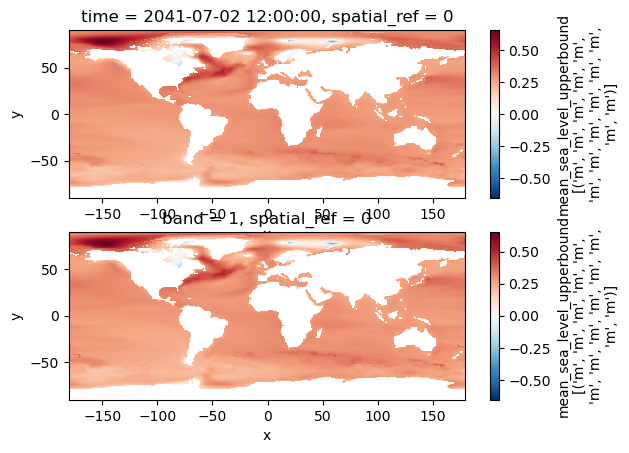

<IPython.core.display.Javascript object>

In [10]:
fig, axs = plt.subplots(2,1)
# Plot original data
slp_test.isel(time = 1)['msl_h'].plot.pcolormesh(ax=axs[0])

# Plot newly created data
slp_check = rio.open_rasterio(r"p:\11207608-coclico\FULLTRACK_DATA\WP3\cog\2041\msl_h.tif")
slp_check.plot(ax=axs[1])
print('Hopefully data is the same')

In [11]:
# Hard code the various ssp scenarios considered
scens = 'high_end', 'ssp126', 'ssp245', 'ssp585'

# List all nc-files from data folder
file_list = glob.glob(str(ds_dir.joinpath("*.nc")))

for scen, file in zip(scens, file_list):
    if not scen in file:
        raise ValueError('The some or more of the strings defined in scens are not found in your file_list')
        
for scen, file in zip(scens, file_list):

    slp = xr.open_dataset(file, engine="rasterio", mask_and_scale=False) 

    for var in slp:
        for itime, time in enumerate(slp['time'].values):    
            
            # Select the variable and timestep from dataset
            da = slp[var].isel(time = itime)
            da.drop('time')

            # Set no data values
            da = (
            da.where(da != -2147483648, -9999)
            .astype("float64")
            .rio.write_nodata(-9999)
            .rio.set_spatial_dims(x_dim="x", y_dim="y")
            )

            # Set final output file name, nc-file is broken down into tif's 
            item_name = str(time.year) + '.tif'
            
            # convert to dataset
            dad = da.to_dataset()

            # add all attributes (again)
            for attr_name, attr_val in meta_data.items():
                if attr_name == 'PROVIDERS':
                    attr_val = json.dumps(attr_val)
                if attr_name == "MEDIA_TYPE":       # change media type to tiff, leave the rest as is
                    attr_val = "IMAGE/TIFF"
                if attr_name == 'TEMPORAL_EXTENT':  # only add the relevant year to the tif
                    attr_val = attr_val[itime]  	# NOTE: coded to match timing of the netcdf
                dad.attrs[attr_name] = attr_val


            dad.attrs['Conventions'] = "CF-1.8"

            # Remove leftover NETCDF attributes
            attrs_del = 'NETCDF_DIM_EXTRA','NETCDF_DIM_time_DEF','NETCDF_DIM_time_VALUES'
            for attr_del in attrs_del:
                del dad[var].attrs[attr_del]

            # export file
            outpath = cog_dirs.joinpath(scen, str(var))
            outpath.mkdir(parents=True, exist_ok=True)
            outpath = outpath.joinpath(item_name)
            dad.rio.to_raster(outpath, compress = 'DEFLATE', driver= 'COG')

<IPython.core.display.Javascript object>